In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import data_handler as dh
import semeval_data_helper as sdh


# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
# plt.rcParams['figure.figsize'] = (16,9)

import mpld3

In [2]:
# reload(sdh)

In [3]:
# reload(nn)
import relembed as nn

In [4]:
# reload(eh)
import experiment_helper as eh

In [5]:
shuffle_seed = 20

In [6]:
reload(dh)
DH = dh.DataHandler('data/semeval_wiki_sdp_10000', valid_percent=10, shuffle_seed=shuffle_seed) # for semeval

Creating Data objects...
Done creating Data objects
85137 total examples :: 76623 training : 8514 valid (90:10 split)
Vocab size: 23108 Dep size: 49 POS size: 18


In [7]:
# reload(sdh)
train, valid, test, label2int, int2label = sdh.load_semeval_data(include_ends=False, shuffle_seed=shuffle_seed)
num_classes = len(int2label.keys())

Didn't find common ancestor
1790	"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."

(The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport )
Bad sentence: '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
((The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport ), None)
Skipping this one... '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
(None, None, None, 4)
Num training: 7199
Num valididation: 800
Didn't find common ancestor
8310	"Tributes have been paid to the <e1>writer</e1> who created Goodness Gracious Me, the hit BBC television <e2>series</e2>."

(Tributes have been paid to the writer 

In [8]:
# convert the semeval data to indices under the wiki vocab:
train['sdps'] = DH.sentences_to_sequences(train['sdps'])
valid['sdps'] = DH.sentences_to_sequences(valid['sdps'])
test['sdps'] = DH.sentences_to_sequences(test['sdps'])
    
train['targets'] = DH.sentences_to_sequences(train['targets'])
valid['targets'] = DH.sentences_to_sequences(valid['targets'])
test['targets'] = DH.sentences_to_sequences(test['targets'])

print(train['targets'][:5]) # small sample

[[198, 183], [269, 20542], [4878, 262], [1047, 706], [1084, 2143]]


In [9]:
max_seq_len = max([len(path) for path in train['sdps']+valid['sdps']+test['sdps']])
print(max_seq_len, DH.max_seq_len)
DH.max_seq_len = max_seq_len

13 13


In [10]:
# the embedding matrix is started of as random uniform [-1,1]
# then we replace everything but the OOV tokens with the approprate google vector
fname = 'data/GoogleNews-vectors-negative300.bin'
word2vec = Word2Vec.load_word2vec_format(fname, binary=True)

word_embeddings = np.random.uniform(low=-1., high=1., size=[DH.vocab_size, 300]).astype(np.float32)
num_found = 0
for i, token in enumerate(DH.vocab):
    if token in word2vec:
        word_embeddings[i] = word2vec[token]
        num_found += 1
print("%i / %i pretrained" % (num_found, DH.vocab_size))
del word2vec # save a lot of RAM
# normalize them
word_embeddings /= np.sqrt(np.sum(word_embeddings**2, 1, keepdims=True))

19761 / 23108 pretrained


In [11]:
def reset_drnn(model_name='relembed', bi=True, dep_embed_size=25, pos_embed_size=25, 
               word_embed_size=None, max_grad_norm=3., max_to_keep=10,
               supervised=True, interactive=True):
    if word_embed_size:    
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':word_embed_size,
            'dep_embed_size':dep_embed_size,
            'pos_embed_size':pos_embed_size,
            'bidirectional':bi,
            'supervised':supervised,
            'interactive':interactive,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'pos_vocab_size':DH.pos_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':None,
            'max_grad_norm':3.,
            'model_name':model_name,
            'max_to_keep':max_to_keep,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    else: # use pretrained google vectors
        config = {
            'max_num_steps':DH.max_seq_len,
            'word_embed_size':300,
            'dep_embed_size':dep_embed_size,
            'pos_embed_size':pos_embed_size,
            'bidirectional':bi,
            'supervised':supervised,
            'interactive':interactive,
            'hidden_layer_size':1000,
            'vocab_size':DH.vocab_size,
            'dep_vocab_size':DH.dep_size,
            'pos_vocab_size':DH.pos_size,
            'num_predict_classes':num_classes,
            'pretrained_word_embeddings':word_embeddings,
            'max_grad_norm':3.,
            'model_name':model_name,            
            'max_to_keep':max_to_keep,
            'checkpoint_prefix':'checkpoints/',
            'summary_prefix':'tensor_summaries/'
        }
    try:
        tf.reset_default_graph()
    except:
        pass
    try:
        tf.get_default_session().close()
    except:
        pass
    drnn = nn.RelEmbed(config)
    print(drnn)
    return drnn
# drnn = reset_drnn()

In [35]:
def run_validation_test(num_nearby=20):
    valid_phrases, valid_targets , _, valid_lens,_ = DH.validation_batch()
    random_index = int(random.uniform(0, len(valid_lens)))
    query_phrase = valid_phrases[random_index]
    query_len = valid_lens[random_index]
    query_target = valid_targets[random_index].reshape((1,2))
    padded_qp = np.zeros([DH.max_seq_len, 3]).astype(np.int32)
    padded_qp[:len(query_phrase), 0] = [x[0] for x in query_phrase]
    padded_qp[:len(query_phrase), 1] = [x[1] for x in query_phrase]    
    padded_qp[:len(query_phrase), 2] = [x[2] for x in query_phrase]    

    dists, phrase_idx = drnn.validation_phrase_nearby(padded_qp, query_len, query_target,
                                                      valid_phrases, valid_lens, valid_targets)
    print("="*80)
    print("Top %i closest phrases to <%s> '%s' <%s>" 
          % (num_nearby, DH.vocab_at(query_target[0,0]), 
             DH.sequence_to_sentence(query_phrase, query_len), 
             DH.vocab_at(query_target[0,1])))
    for i in range(num_nearby):
        dist = dists[i]
        phrase = valid_phrases[phrase_idx[i]]
        len_ = valid_lens[phrase_idx[i]]
        target = valid_targets[phrase_idx[i]]
        print("%i: %0.3f : <%s> '%s' <%s>" 
              % (i, dist, DH.vocab_at(target[0]),
                 DH.sequence_to_sentence(phrase, len_),
                 DH.vocab_at(target[1])))
    print("="*80)
#     drnn.save_validation_accuracy(frac_correct)

In [32]:
def time_left(num_epochs, num_steps, fit_time, nearby_time, start_time, nearby_mod):
    total = num_epochs*num_steps*fit_time + ((num_epochs*num_steps)/float(nearby_mod))*nearby_time
    return total - (time() - start_time)

## Unsupervised

In [41]:
reload(nn)
drnn = reset_drnn(model_name='renormalize', bi=False, max_to_keep=0)

# hyperparameters
num_epochs = 1
batch_size =50
neg_per = 10
neg_level= 1
target_neg = True

num_nearby = 50
nearby_mod = 200
sample_power = .75
DH.scale_vocab_dist(sample_power)
DH.scale_target_dist(.5)

# bookkeeping
num_steps = DH.num_steps(batch_size)
total_step = 1
save_interval = 30 * 60 # half hour in seconds
save_time = time()

#timing stuff
start = time()
fit_time = 0
nearby_time = 0

for epoch in range(num_epochs):
    offset = 0 #if epoch else 400
    DH.shuffle_data()
    for step , batch in enumerate(DH.batches(batch_size, offset=offset, 
                                             neg_per=neg_per, neg_level=neg_level, target_neg=target_neg)):
        inputs, targets, labels, lengths, _ = batch
        if not step: step = offset
        t0 = time()
        loss = drnn.partial_unsup_fit(inputs, targets, labels, lengths)
        fit_time = (fit_time * float(total_step) +  time() - t0) / (total_step + 1) # running average
        if step % 10 == 0:
            m,s = divmod(time()-start, 60)
            h,m = divmod(m, 60)
            left = time_left(num_epochs, num_steps, fit_time, nearby_time, start, nearby_mod)
            ml,sl = divmod(left, 60)
            hl,ml = divmod(ml, 60)
            pps = batch_size*(neg_per + 1) / fit_time 
            print("(%i:%i:%i) step %i/%i, epoch %i Training Loss = %1.5f :: %0.3f phrases/sec :: (%i:%i:%i) hours left" 
                  % (h,m,s, step, num_steps, epoch, loss, pps, hl, ml, sl))
        if (total_step-1) % nearby_mod == 0: # do one right away so we get a good timing estimate
            t0 = time()
            run_validation_test(num_nearby) # check out the nearby phrases in the validation set
            inputs, targets, labels, lengths, _ = DH.validation_batch()
            valid_loss = drnn.validation_loss(inputs, targets, labels, lengths)
            print("Validation loss: %0.4f" % valid_loss)
            nearby_time = (nearby_time * float(total_step) + time() - t0) / (total_step + 1) # running average

        if (time() - save_time) > save_interval:
            print("Saving model...")
            drnn.checkpoint()
            save_time = time()
        total_step +=1
drnn.checkpoint()

<DPNN: W:300, D:25, P:25 H:600, V:23108>
(0:0:4) step 0/1532, epoch 0 Training Loss = 0.69158 :: 453.910 phrases/sec :: (0:30:51) hours left
Top 50 closest phrases to <bruce> '<X> by attacked in <Y>' <south>
0: 1.000 : <bruce> '<X> by attacked in <Y>' <south>
1: 0.947 : <base> '<X> attacked in <Y>' <battle>
2: 0.886 : <goal> '<X> by followed in <Y>' <march>
3: 0.875 : <stadium> '<X> at defeated in <Y>' <front>
4: 0.872 : <states> '<X> in in <Y>' <midwest>
5: 0.872 : <bay> '<X> in in <Y>' <locations>
6: 0.872 : <florida> '<X> in in <Y>' <u.s.>
7: 0.872 : <europe> '<X> in in <Y>' <pacific>
8: 0.869 : <he> '<X> defeated in <Y>' <rounds>
9: 0.867 : <rose> '<X> was in <Y>' <band>
10: 0.867 : <appointment> '<X> in <Y>' <favour>
11: 0.867 : <time> '<X> in <Y>' <london>
12: 0.867 : <acid> '<X> in <Y>' <reactions>
13: 0.867 : <louvre> '<X> in <Y>' <paris>
14: 0.867 : <term> '<X> in <Y>' <election>
15: 0.867 : <offices> '<X> in <Y>' <boston>
16: 0.867 : <degree> '<X> in <Y>' <geology>
17: 0.867 

'checkpoints/renormalize.ckpt-1532-0'

(-100, 10000)

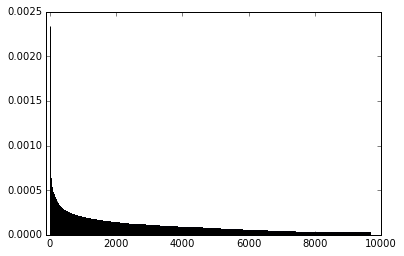

In [20]:
DH.scale_target_dist(.5)
plt.bar(range(len(DH._target_dist)), sorted(DH._target_dist, reverse=True))
plt.xlim(-100,10000)